In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

plt.rcParams ['font.sans-serif'] ='SimHei'               #显示中文
plt.rcParams ['axes.unicode_minus']=False               #显示负号

## 读取数据查看信息

In [57]:
df=pd.read_csv('Clean Data_pakwheels.csv')
df=df[[col for col in df.columns if 'Unnamed' not in col]]
df.head(2)

,Company Name,Model Name,Price,Model Year,Location,Mileage,Engine Type,Engine Capacity,Color,Assembly,Body Type,Transmission Type,Registration Status
0,Toyota,Vitz,2385000,2017,Islamabad,9869,Petrol,1000,Silver,Imported,Hatchback,Automatic,Un-Registered
1,Toyota,Corolla,111000,2019,KPK,11111,Petrol,1300,White,Local,Sedan,Automatic,Registered


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46022 entries, 0 to 46021
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Company Name         46022 non-null  object
 1   Model Name           46022 non-null  object
 2   Price                46022 non-null  int64 
 3   Model Year           46022 non-null  int64 
 4   Location             46022 non-null  object
 5   Mileage              46022 non-null  int64 
 6   Engine Type          46022 non-null  object
 7   Engine Capacity      46022 non-null  int64 
 8   Color                46022 non-null  object
 9   Assembly             46022 non-null  object
 10  Body Type            46022 non-null  object
 11  Transmission Type    46022 non-null  object
 12  Registration Status  46022 non-null  object
dtypes: int64(4), object(9)
memory usage: 4.6+ MB


|英文列名称|	中文列名称|	描述
|-----------|----------|--------
|Company Name|	公司名称|	汽车制造商的名称。
|Model Name	|型号名称|	汽车的型号。
|Price	|价格	|汽车的售价。
|Model Year|	模型年份	|汽车制造的年份。
|Location	|位置	|汽车的所在地或销售地。
|Mileage	|里程	|汽车已经行驶的总里程数。
|Engine Type	|引擎类型	|汽车的引擎类型（如柴油、汽油）。
|Engine Capacity	|引擎容量|	汽车引擎的容量或大小。
|Color	|颜色	|汽车的颜色。
|Assembly	|组装	|汽车是在本地组装还是进口组装。
|Body Type	|车身类型	|汽车的车身形状（如轿车、SUV）。
|Transmission Type	|变速器类型	|汽车的变速器类型（如自动、手动）。
|Registration Status	|注册状态	|汽车的注册情况（如已注册、未注册）。

<Axes: >

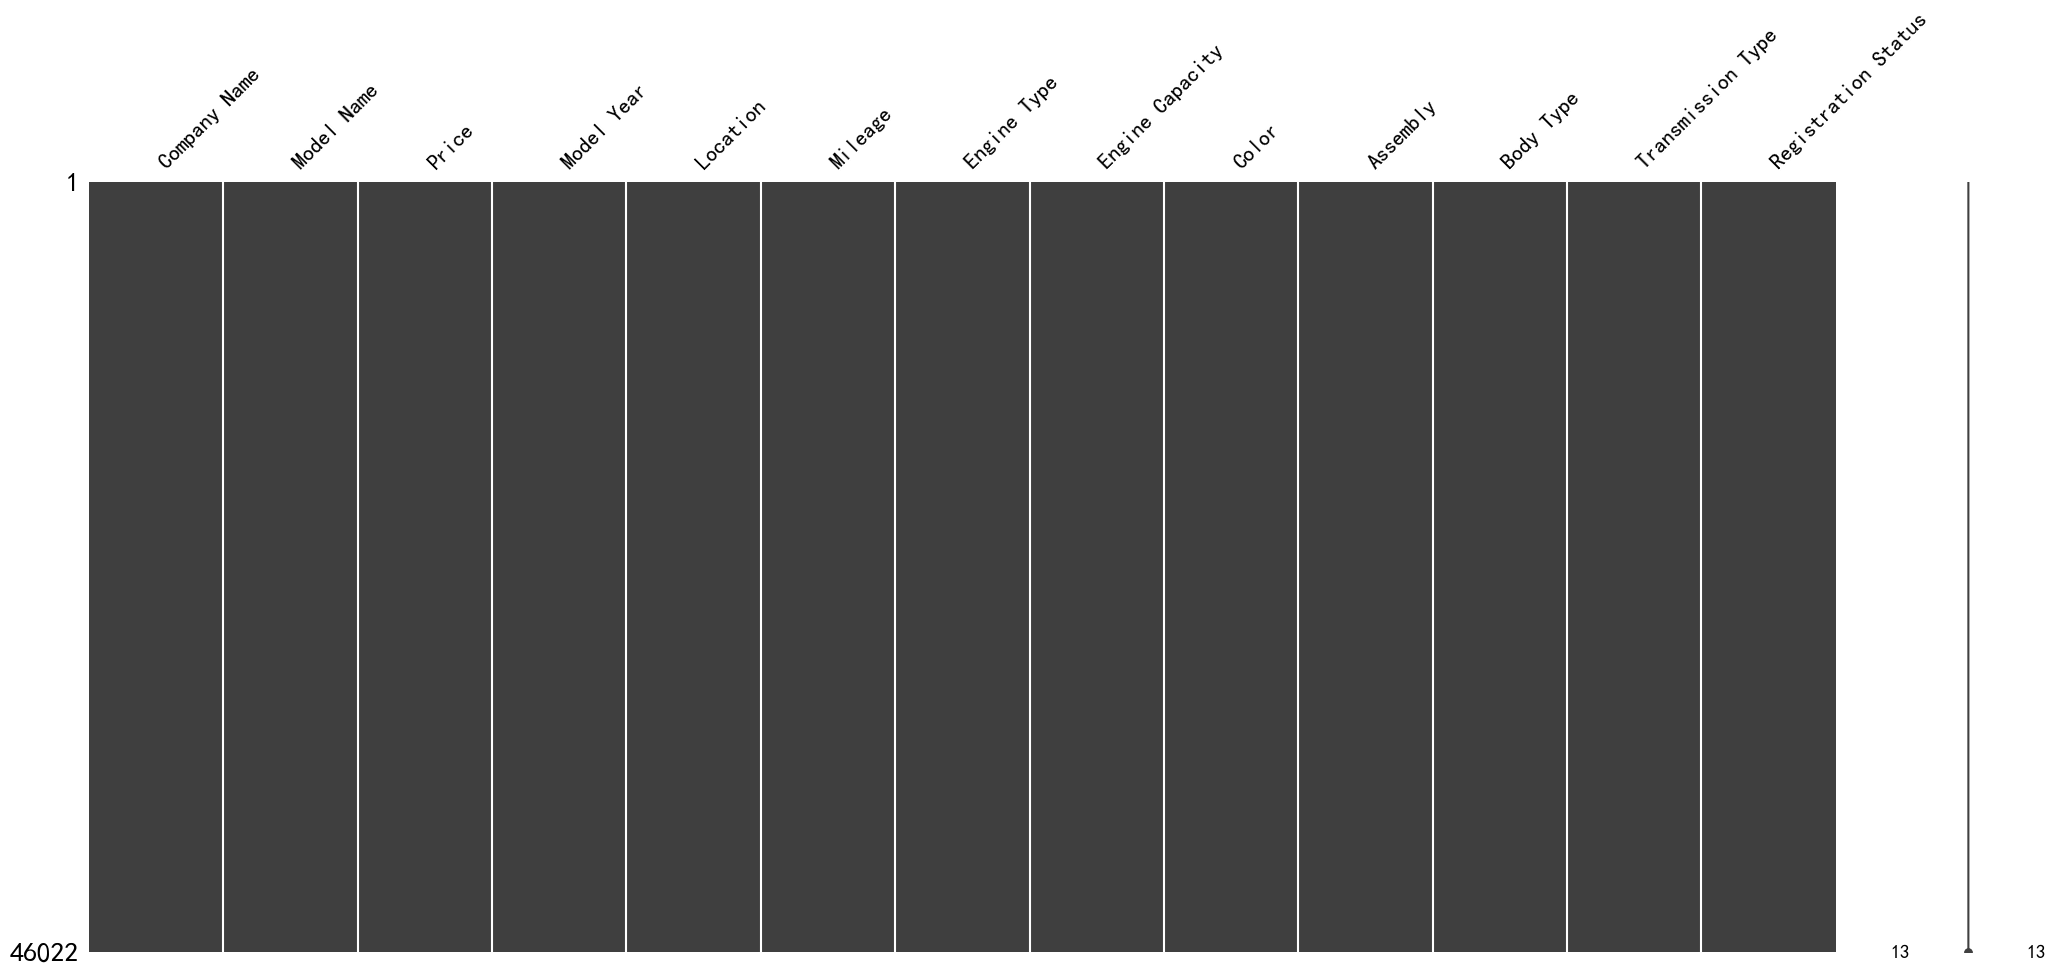

In [59]:
#观察缺失值
import missingno as msno
msno.matrix(df)

## 没有缺失值，直接开始特征工程

In [60]:
#查看数值型数据,
pd.set_option('display.max_columns', 30)
df.select_dtypes(exclude=['object']).head()

,Price,Model Year,Mileage,Engine Capacity
0,2385000,2017,9869,1000
1,111000,2019,11111,1300
2,1530000,2019,17500,660
3,1650000,2019,9600,660
4,1435000,2010,120000,1300


Price作为响应变量y，Model Year转为车龄age，其他变量不用处理

In [61]:
y=df['Price']; df['age']=2024-df['Model Year']  

In [62]:
#查看非数值型数据
df.select_dtypes(exclude=['int64','float64']).head()

,Company Name,Model Name,Location,Engine Type,Color,Assembly,Body Type,Transmission Type,Registration Status
0,Toyota,Vitz,Islamabad,Petrol,Silver,Imported,Hatchback,Automatic,Un-Registered
1,Toyota,Corolla,KPK,Petrol,White,Local,Sedan,Automatic,Registered
2,Suzuki,Alto,KPK,Petrol,White,Local,Hatchback,Automatic,Un-Registered
3,Suzuki,Alto,Punjab,Petrol,White,Local,Hatchback,Manual,Registered
4,Toyota,Corolla,Islamabad,Petrol,Black,Local,Sedan,Manual,Registered


In [63]:
for col in df.select_dtypes(exclude=['int64','float64']).columns:
    print(f'{col}特征类别数量为{len(df[col].unique())}')

Company Name特征类别数量为31
Model Name特征类别数量为196
Location特征类别数量为6
Engine Type特征类别数量为3
Color特征类别数量为24
Assembly特征类别数量为2
Body Type特征类别数量为6
Transmission Type特征类别数量为2
Registration Status特征类别数量为2


其中，
- Model Name特征变量类别太多，进行删除。
- 颜色24类有很多类似的颜色可以进行归类，减少变量。
    - Silver/Grey: 包括银色和灰色。
    - White/Beige: 包括白色和米色。
    - Black: 只包括黑色。
    - Brown系: 包括棕色、栗色、褐红色和铜色。
    - Gold: 只包括金色。
    - Blue系: 包括蓝色、海军蓝和靛蓝。
    - Red系: 包括红色、粉色、洋红和酒红色。
    - Green系: 包括绿色和绿松石色。
    - Orange: 只包括橙色。
    - Purple: 只包括紫色。
    - Yellow: 只包括黄色。
    - Unlisted: 包括未列出的颜色。
- Company Name特征类别数量为31，也要进行适当的归类处理

In [64]:
df=df.drop(columns=['Model Name'])

In [65]:
color_mapping = {
    'Silver': ['Silver', 'Grey'],
    'White': ['White', 'Beige'],
    'Black': ['Black'],
    'Brown': ['Brown', 'Maroon', 'Burgundy', 'Bronze'],
    'Gold': ['Gold'],
    'Blue': ['Blue', 'Navy', 'Indigo'],
    'Red': ['Red', 'Pink', 'Magenta', 'Wine'],
    'Green': ['Green', 'Turquoise'],
    'Orange': ['Orange'],
    'Purple': ['Purple'],
    'Yellow': ['Yellow'],
    'Unlisted': ['Unlisted', 'Assembly']  
}
inverse_color_mapping = {val: key for key, vals in color_mapping.items() for val in vals}
# 映射
df['Color'] = df['Color'].map(inverse_color_mapping)
print(len(df['Color'].unique()))

12


In [66]:
### 等同下面这个方法
inverse_color_mapping = {}

# 对原始字典进行双重循环
for main_color, variations in color_mapping.items():
    for color in variations:
        # 将变体颜色作为键，主要颜色作为值添加到字典中
        inverse_color_mapping[color] = main_color
inverse_color_mapping

{'Silver': 'Silver',
 'Grey': 'Silver',
 'White': 'White',
 'Beige': 'White',
 'Black': 'Black',
 'Brown': 'Brown',
 'Maroon': 'Brown',
 'Burgundy': 'Brown',
 'Bronze': 'Brown',
 'Gold': 'Gold',
 'Blue': 'Blue',
 'Navy': 'Blue',
 'Indigo': 'Blue',
 'Red': 'Red',
 'Pink': 'Red',
 'Magenta': 'Red',
 'Wine': 'Red',
 'Green': 'Green',
 'Turquoise': 'Green',
 'Orange': 'Orange',
 'Purple': 'Purple',
 'Yellow': 'Yellow',
 'Unlisted': 'Unlisted',
 'Assembly': 'Unlisted'}

#### 颜色类别减少为12，下面对汽车品牌处理

In [72]:
c=df['Company Name'].value_counts()  # 统计每个品牌车辆的样本数量，然后计算每个品牌车辆的均价
df.groupby(['Company Name']).mean(numeric_only=True).loc[c.index,:].assign(count=c.to_numpy())[['Price','count']].style.bar(align='mid', color=['#491256', 'skyblue'])

,Price,count
Suzuki,902034.056698,15944
Toyota,2995425.321337,15560
Honda,2144227.690644,9245
Daihatsu,1170548.443665,2281
Nissan,1604033.043478,575
Mitsubishi,1260086.345382,498
Mercedes,5253756.321839,435
Hyundai,621797.222222,360
Audi,8582802.884615,208
FAW,1016508.021390,187


Suzuki，Toyota，Honda，Daihatsu四个品牌已经大概包含了大部分车辆，其他的剩下面的车辆可以归为一类，
但是有些牌子可能是奢侈品豪车，均价超级贵，所以我们把下面的Price均价分为三个区间，0-100w的作为普通其他类，100w-500w作为中档其他类，500w以上为高档其他类

In [73]:
c_p=df.groupby(['Company Name']).mean(numeric_only=True).loc[c.index,:]['Price'].iloc[4:]
print(f'普通其他类:{c_p[c_p<1000000].index}')
print(f'中档其他类:{c_p[(c_p > 1000000) & (c_p < 5000000)].index}')
print(f'高档其他类:{c_p[c_p>5000000].index}')

普通其他类:Index(['Hyundai', 'United', 'Daewoo', 'Chevrolet', 'Chery', 'Fiat', 'Adam'], dtype='object')
中档其他类:Index(['Nissan', 'Mitsubishi', 'FAW', 'Mazda', 'KIA', 'Subaru', 'SsangYong',
       'Land', 'DFSK', 'Jeep', 'MINI', 'Volvo'],
      dtype='object')
高档其他类:Index(['Mercedes', 'Audi', 'BMW', 'Lexus', 'Range', 'Porsche', 'Hummer',
       'Jaguar'],
      dtype='object')


In [14]:
brand_mapping = {
    'Suzuki': 'Suzuki',
    'Toyota': 'Toyota',
    'Honda': 'Honda',
    'Daihatsu': 'Daihatsu',   #这四个牌子保留
    'General': ['Hyundai', 'United', 'Daewoo', 'Chevrolet', 'Chery', 'Fiat', 'Adam'],
    'Mid-Range': ['Nissan', 'Mitsubishi', 'FAW', 'Mazda', 'KIA', 'Subaru', 'SsangYong', 'Land', 'DFSK', 'Jeep', 'MINI', 'Volvo'],
    'Premium': ['Mercedes', 'Audi', 'BMW', 'Lexus', 'Range', 'Porsche', 'Hummer', 'Jaguar'] }
# Inverting the mapping
inverse_brand_mapping = {val: key for key, vals in brand_mapping.items() for val in ([vals] if isinstance(vals, str) else vals)}
df['Company Name'] = df['Company Name'].map(inverse_brand_mapping, na_action='ignore')  # na_action='ignore' to keep the original value if not found in mapping
print(len(df['Company Name'].unique()))

7


In [15]:
### 等同下面这个方法
inverse_brand_mapping = {}

# 对原始字典进行双重循环
for brand, models in brand_mapping.items():
    # 检查models是否是字符串类型，如果是，将其转换为列表
    if isinstance(models, str):
        models = [models]
    # 遍历模型列表
    for model in models:
        # 将牌子作为键，品牌作为值添加到字典中
        inverse_brand_mapping[model] = brand
inverse_brand_mapping

{'Suzuki': 'Suzuki',
 'Toyota': 'Toyota',
 'Honda': 'Honda',
 'Daihatsu': 'Daihatsu',
 'Hyundai': 'General',
 'United': 'General',
 'Daewoo': 'General',
 'Chevrolet': 'General',
 'Chery': 'General',
 'Fiat': 'General',
 'Adam': 'General',
 'Nissan': 'Mid-Range',
 'Mitsubishi': 'Mid-Range',
 'FAW': 'Mid-Range',
 'Mazda': 'Mid-Range',
 'KIA': 'Mid-Range',
 'Subaru': 'Mid-Range',
 'SsangYong': 'Mid-Range',
 'Land': 'Mid-Range',
 'DFSK': 'Mid-Range',
 'Jeep': 'Mid-Range',
 'MINI': 'Mid-Range',
 'Volvo': 'Mid-Range',
 'Mercedes': 'Premium',
 'Audi': 'Premium',
 'BMW': 'Premium',
 'Lexus': 'Premium',
 'Range': 'Premium',
 'Porsche': 'Premium',
 'Hummer': 'Premium',
 'Jaguar': 'Premium'}

In [16]:
for col in df.select_dtypes(exclude=['int64','float64']).columns:
    print(f'{col}特征类别数量为{len(df[col].unique())}')

Company Name特征类别数量为7
Location特征类别数量为6
Engine Type特征类别数量为3
Color特征类别数量为12
Assembly特征类别数量为2
Body Type特征类别数量为6
Transmission Type特征类别数量为2
Registration Status特征类别数量为2


In [17]:
df=df.drop(columns=['Price'])

除了完毕，画图！

## 数据画图探索

### 数值型变量画图

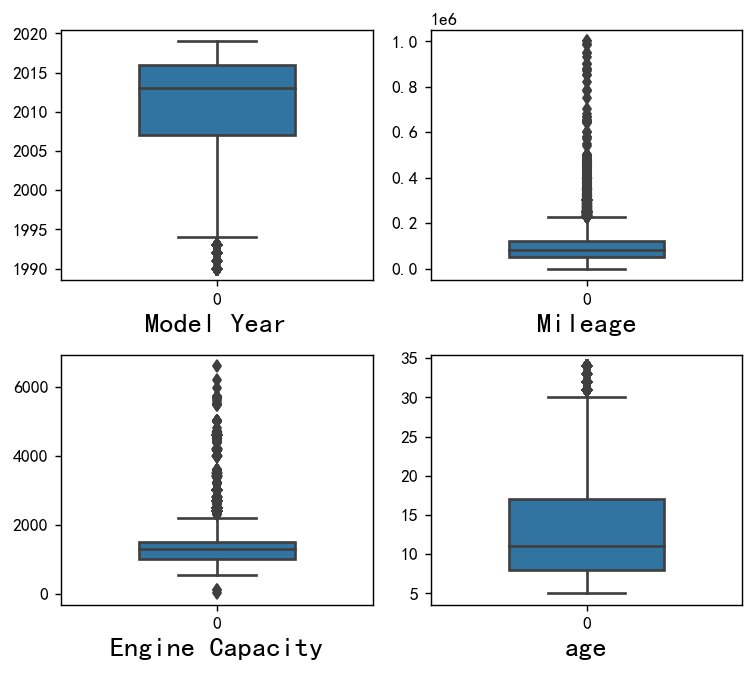

In [18]:
#查看特征变量的箱线图分布
num_columns = df.select_dtypes(exclude=['object']).columns.tolist() # 列表头
dis_cols = 2                   #一行几个
dis_rows = len(num_columns)
plt.figure(figsize=(3 * dis_cols, 2.5 * dis_rows),dpi=128)
 
for i in range(len(num_columns)):
    plt.subplot(dis_rows,dis_cols,i+1)
    sns.boxplot(data=df[num_columns[i]], orient="v",width=0.5)
    plt.xlabel(num_columns[i],fontsize = 16)
plt.tight_layout()
#plt.savefig('特征变量箱线图',formate='png',dpi=500)
plt.show()

车龄存在一些极大异常值，有一些车车龄很大。Mileage ，engine capacity 也有很多极大值

型号年份（Model Year）：大部分车辆的型号年份集中在2005年到2015年之间，中位数大约在2010年左右。这表明大多数车辆相对较新。箱线图下方的长尾表明也有少量较旧的车辆，但这些较老的车辆相对不多。

里程（Mileage）：大多数车辆的里程较低，中位数接近0，但范围广泛，上至100万公里。这说明有些车辆使用非常频繁，但大多数车辆保持较低的里程数。长尾分布表明有些车辆的里程异常高，这可能反映了部分车辆经受了长期的使用。

引擎容量（Engine Capacity）：大部分车辆的引擎容量在0到2000cc之间，中位数在1000cc到1500cc左右。这表明大多数车辆装配的是中小型引擎。存在一些异常点，表明有少量车辆装配了非常小或非常大的引擎。

车龄（Age）：车龄的分布显示，大多数车辆的年龄集中在5到15年之间，中位数约为10年。这意味着大多数车辆都不是很新，但也未达到极老的状态。和型号年份的分析相符，说明市场上流通的车辆大多数都有一定的使用历史。

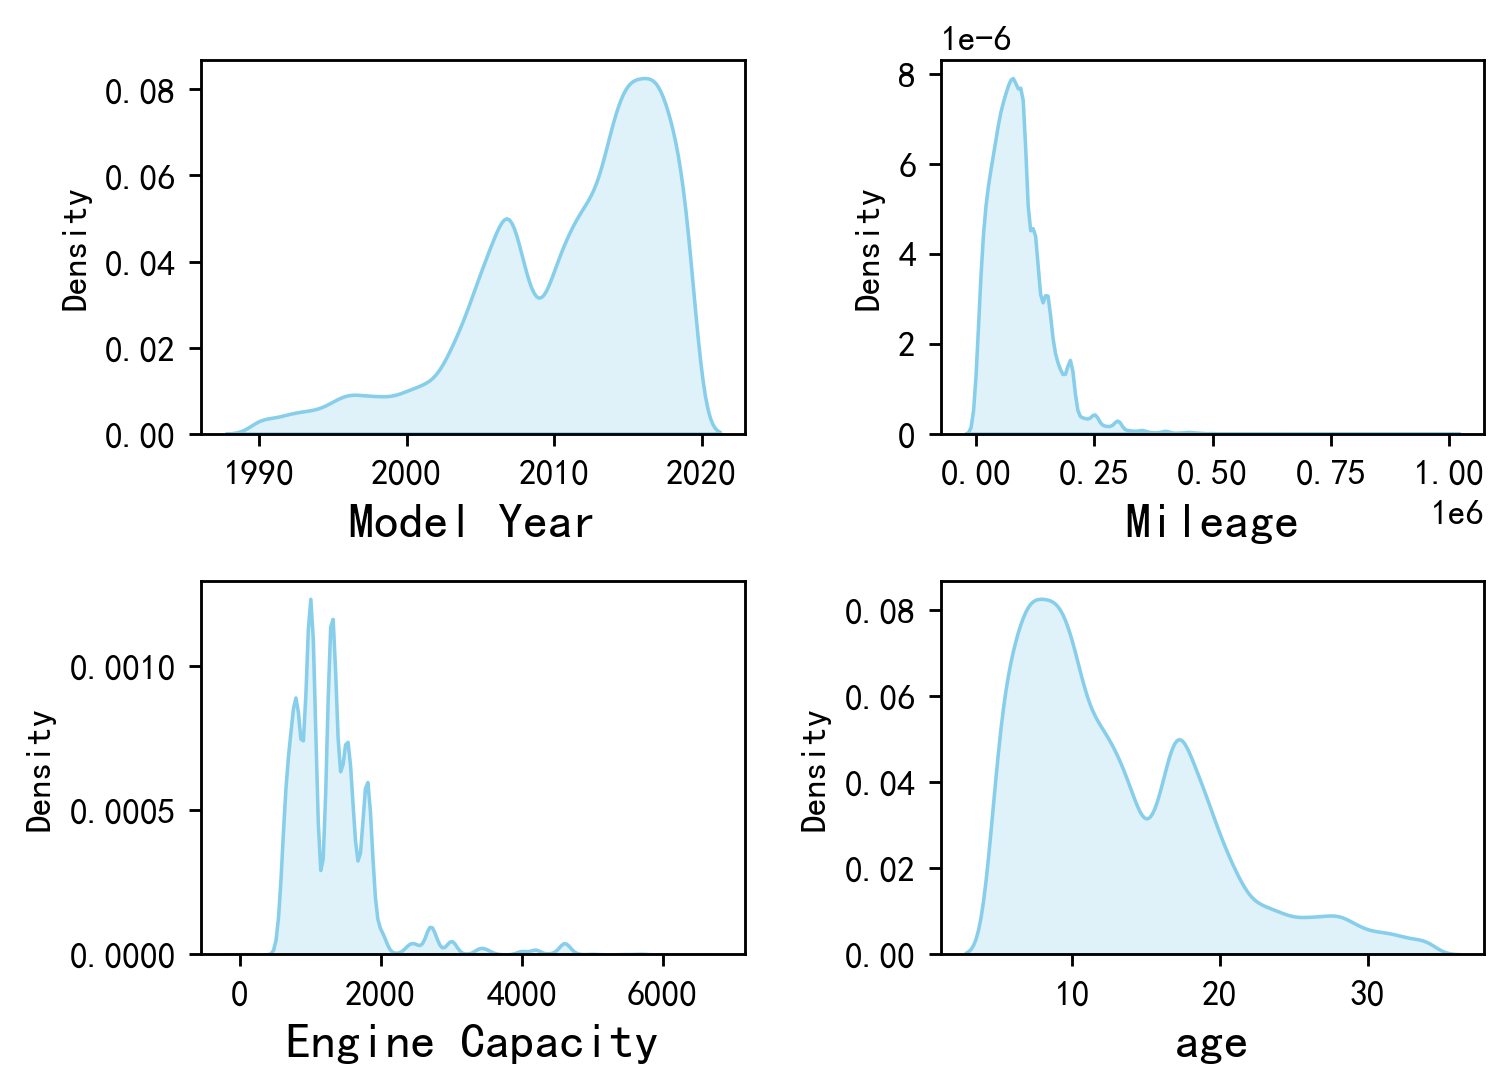

In [19]:
#画密度图，训练集和测试集对比
dis_cols = 2                   #一行几个
dis_rows = len(num_columns)
plt.figure(figsize=(3 * dis_cols, 2 * dis_rows),dpi=256)
 
for i in range(len(num_columns)):
    ax = plt.subplot(dis_rows, dis_cols, i+1)
    ax = sns.kdeplot(df[num_columns[i]], color="skyblue" ,fill=True)
    ax.set_xlabel(num_columns[i],fontsize = 14)
plt.tight_layout()
#plt.savefig('训练测试特征变量核密度图',formate='png',dpi=500)
plt.show()

和上面结论一致，age ， Mileage ，engine capacity ，典型的右偏分布 存在很多极大值

### 分类型变量画图

In [20]:
df.select_dtypes(exclude=['int64','float64']).columns

Index(['Company Name', 'Location', 'Engine Type', 'Color', 'Assembly',
       'Body Type', 'Transmission Type', 'Registration Status'],
      dtype='object')

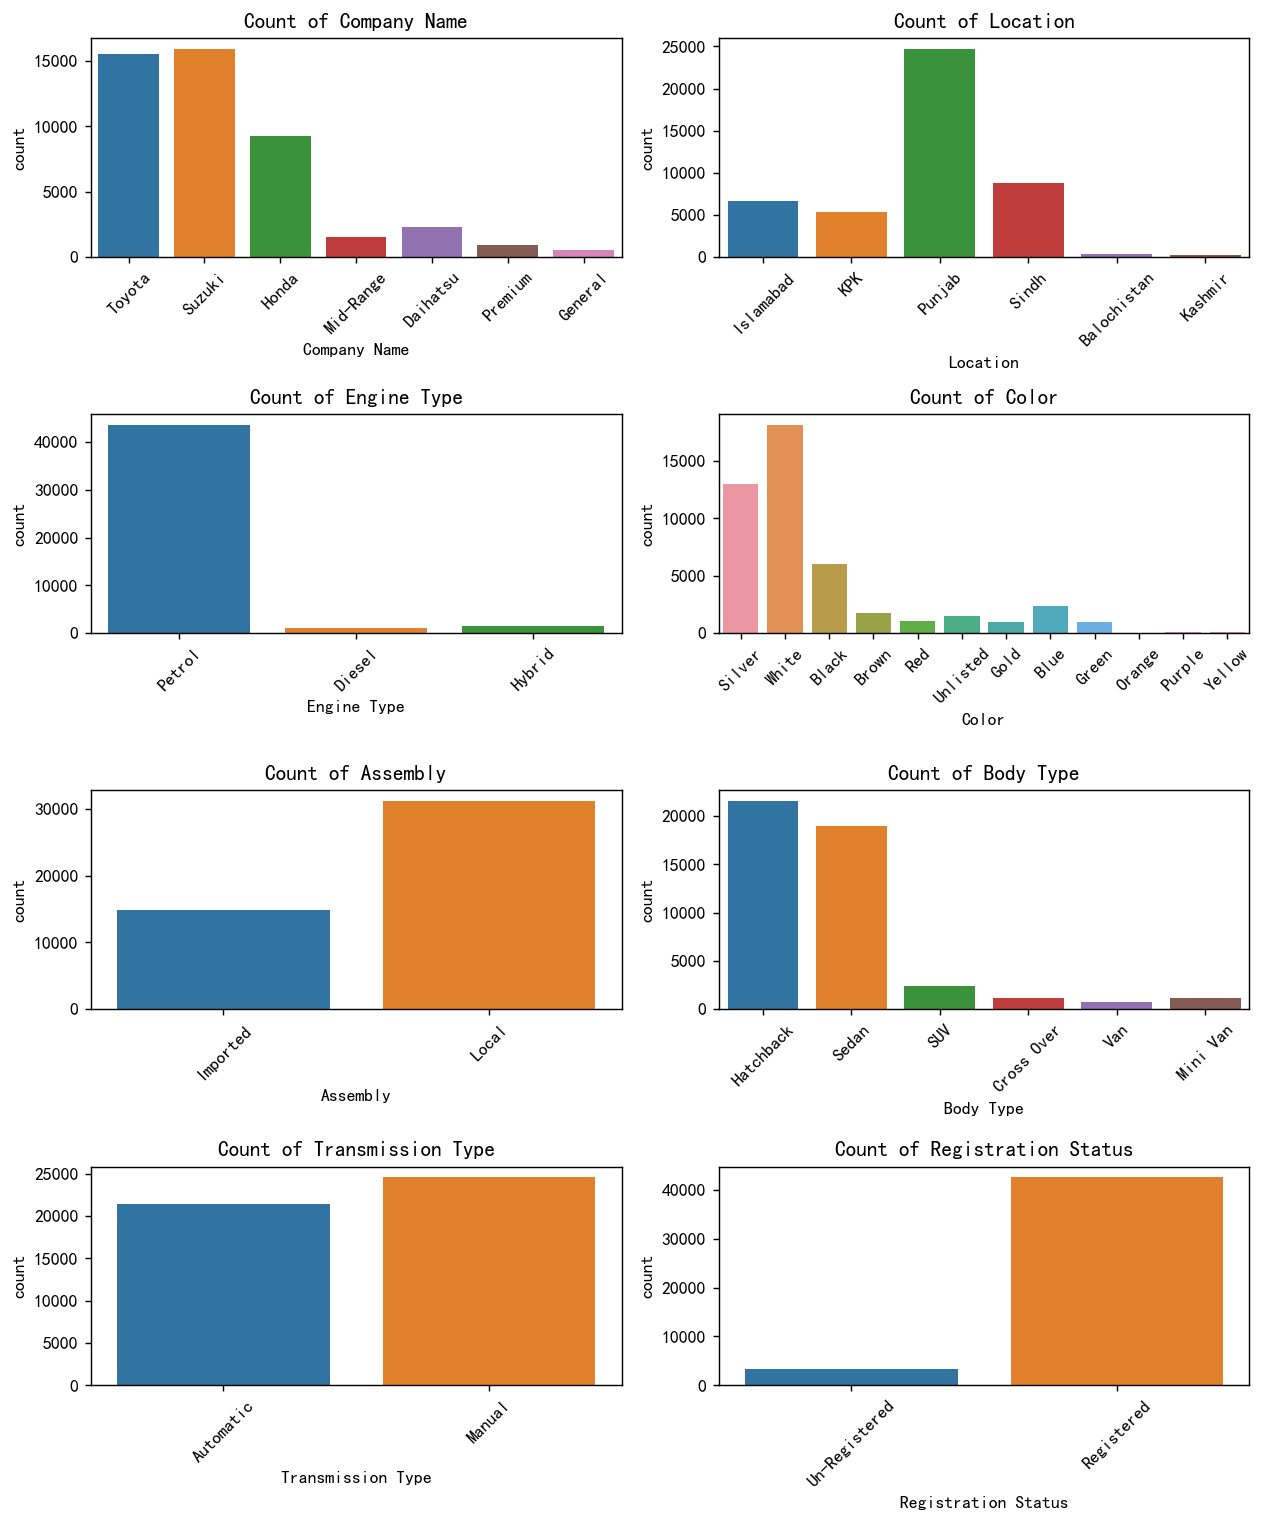

In [21]:
# Select non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['int64', 'float64']).columns
# Set up the matplotlib figure with 2x4 subplots
f, axes = plt.subplots(4, 2, figsize=(10,12),dpi=128)
# Flatten axes for easy iterating
axes_flat = axes.flatten()
# Loop through the non-numeric columns and create a countplot for each
for i, column in enumerate(non_numeric_columns):
    if i < 8:  # Check to avoid IndexError if there are more than 8 non-numeric columns
        sns.countplot(x=column, data=df, ax=axes_flat[i])
        axes_flat[i].set_title(f'Count of {column}')
        for label in axes_flat[i].get_xticklabels():
            label.set_rotation(45)

# Hide any unused subplots
for j in range(i + 1, 8):
    f.delaxes(axes_flat[j])
plt.tight_layout()
plt.show()

公司名称：图表显示Toyota和Suzuki是数量最多的品牌，其次是Honda。这可能表明在相关市场中，Toyota和Suzuki更受欢迎，可能因为它们的可靠性、品牌认知度或性价比。Premium（可能代表高端品牌）和General（可能代表普通或非专门品牌）的数量明显少于前三者，这表明市场可能更倾向于具有中等价格和质量的车辆。

地点：该图展示了汽车的地理分布情况。伊斯兰堡（Islamabad）的数量最多，其次是旁遮普省（Punjab）。这可能反映了这些区域的高车辆需求或更高的购买力。

引擎类型：绝大多数车辆使用的是汽油（Petrol）引擎，而柴油（Diesel）和混合动力（Hybrid）引擎的车辆数量相对较少。这可能是由于汽油车的普及度高，以及在某些地区对于柴油和混合动力车的支持不足。

颜色：银色（Silver）和白色（White）车辆在数量上占据优势，这可能因为这些颜色的车辆更受欢迎，也可能与热量反射能力或经典美观有关。未上市（Unlisted）颜色的数量相对较少，可能包含特殊或定制的颜色。

装配类型：本地装配（Local）的车辆远多于进口车辆（Imported）。这可能反映了本地制造车辆的成本优势或进口税的影响。

车身类型：轿车（Sedan）和掀背车（Hatchback）是最常见的车身类型，而SUV的数量相对较少。这可能反映了市场上对于日常使用和经济型车辆的高需求。

变速器类型：自动档（Automatic）车辆数量少于手动档（Manual）车辆，这可能与成本、驾驶习惯或车辆类型有关。

注册状态：已注册（Registered）的车辆数量远超未注册（Un-Registered）的车辆，这显示了大多数车辆在使用前已完成了注册流程。

### 响应变量y的分布

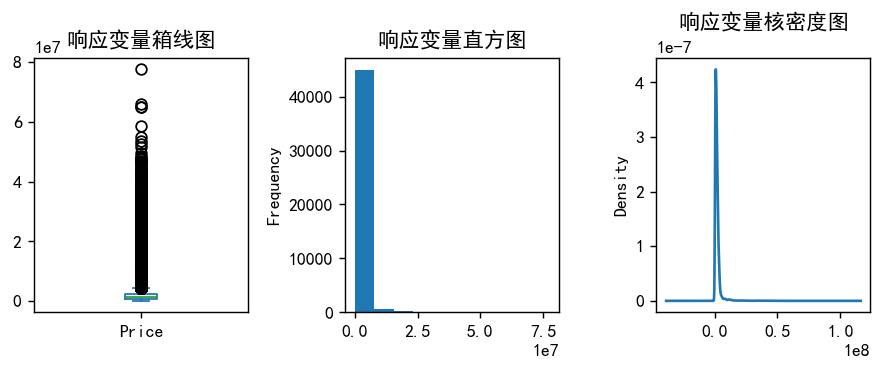

In [22]:
# 查看y的分布
#回归问题
plt.figure(figsize=(7,3),dpi=128)
plt.subplot(1,3,1)
y.plot.box(title='响应变量箱线图')
plt.subplot(1,3,2)
y.plot.hist(title='响应变量直方图')
plt.subplot(1,3,3)
y.plot.kde(title='响应变量核密度图')
#sns.kdeplot(y, color='Red', shade=True)
#plt.savefig('响应变量.png')
plt.tight_layout()
plt.show()

有些车的价格异常值太夸张，处理一些

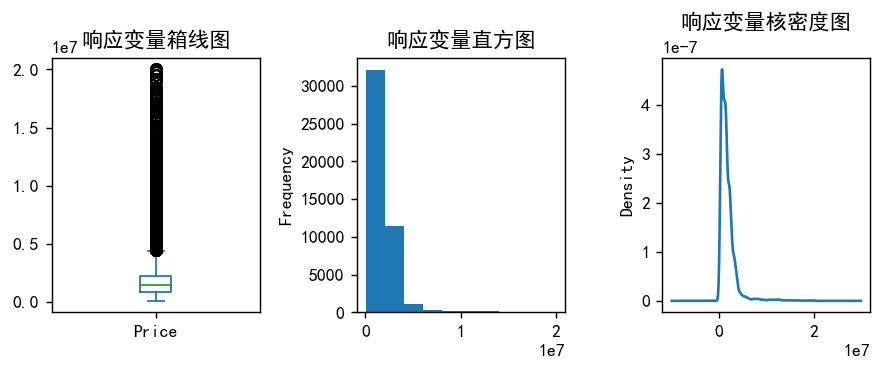

In [23]:
#处理y的异常值  二千万以上的车就去掉
y=y[y <= 20000000]
plt.figure(figsize=(7,3),dpi=128)
plt.subplot(1,3,1)
y.plot.box(title='响应变量箱线图')
plt.subplot(1,3,2)
y.plot.hist(title='响应变量直方图')
plt.subplot(1,3,3)
y.plot.kde(title='响应变量核密度图')
#sns.kdeplot(y, color='Red', shade=True)
#plt.savefig('响应变量.png')
plt.tight_layout()
plt.show()

In [24]:
#筛选给x
df=df.iloc[y.index,:]
print(f'删除了样本数量：{46022-df.shape[0]}')
df.shape

删除了样本数量：254


(45768, 12)

### X异常值处理

In [25]:
#X变量独热处理
X=pd.get_dummies(df)
#X异常值处理，先标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_s = scaler.fit_transform(X)

然后画图查看

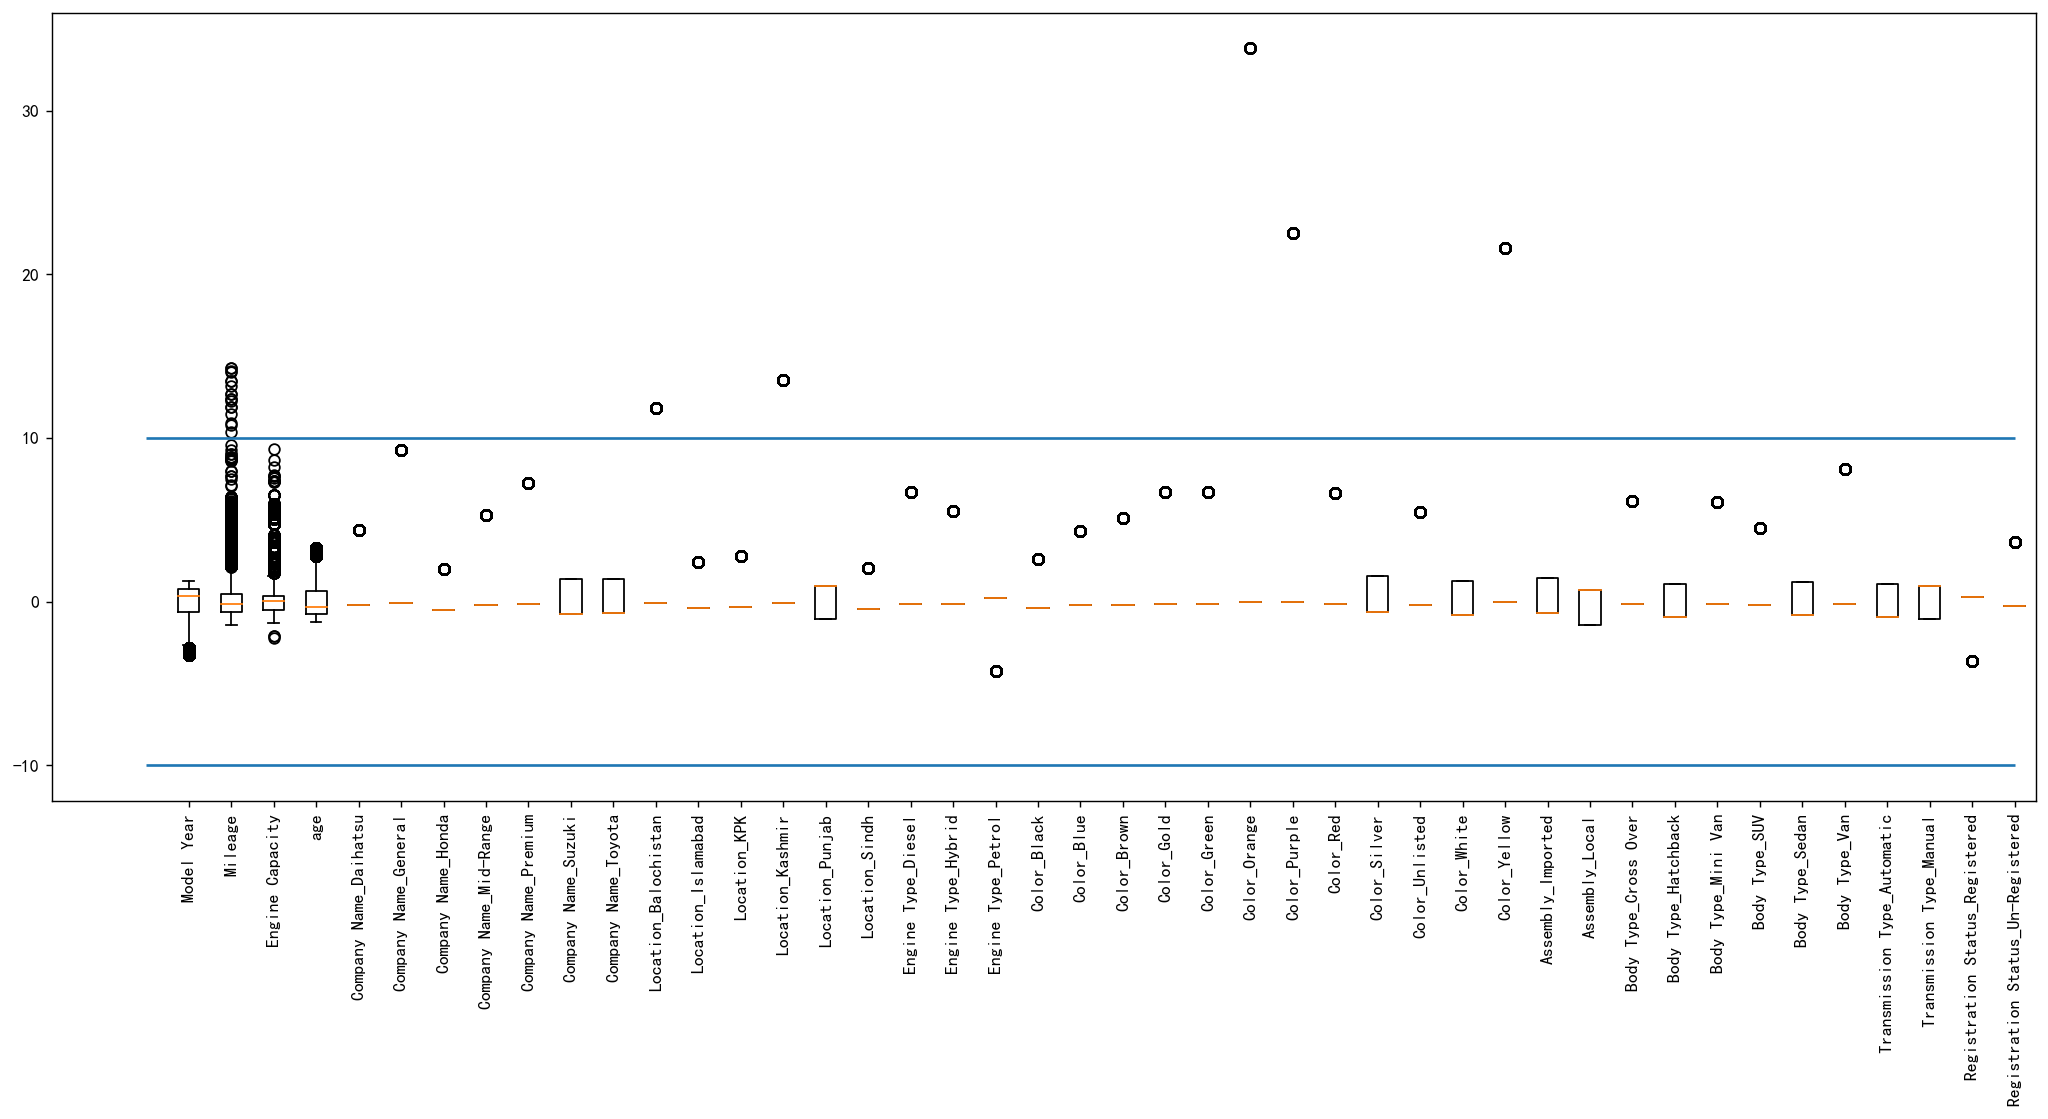

In [26]:
plt.figure(figsize=(20,8),dpi=128)
plt.boxplot(x=X_s,labels=X.columns)
plt.hlines([-10,10],0,len(X.columns))
plt.xticks(rotation=90)
plt.show()

样本个体数据方大于整体数据10倍的标准差之外就筛掉

In [27]:
#异常值多的列进行处理
def deal_outline(data,col,n):   #数据，要处理的列名，几倍的方差
    for c in col:
        mean=data[c].mean()
        std=data[c].std()
        data=data[(data[c]>mean-n*std)&(data[c]<mean+n*std)]
        #print(data.shape)
    return data

In [28]:
X=deal_outline(X,X.columns,10)  #筛掉异常值

In [29]:
#取值唯一的独热变量删除
for col in X.columns:
    if len(X[col].value_counts())==1:
        print(col)
        X.drop(col,axis=1,inplace=True)
y=y[X.index]
print(f'删除了样本数量：{df.shape[0]-X.shape[0]}')
X.shape,y.shape

Location_Balochistan
Location_Kashmir
Color_Orange
Color_Purple
Color_Yellow
删除了样本数量：817


((44951, 39), (44951,))

### 相关系数矩阵

In [30]:
#变量独热之后有点多，就不把颜色和车身类型等变量放上去了
X_plot=X[[col for col in X.columns if 'Color' not in col]]
X_plot=X_plot[[col for col in X_plot.columns if 'Body' not in col]]

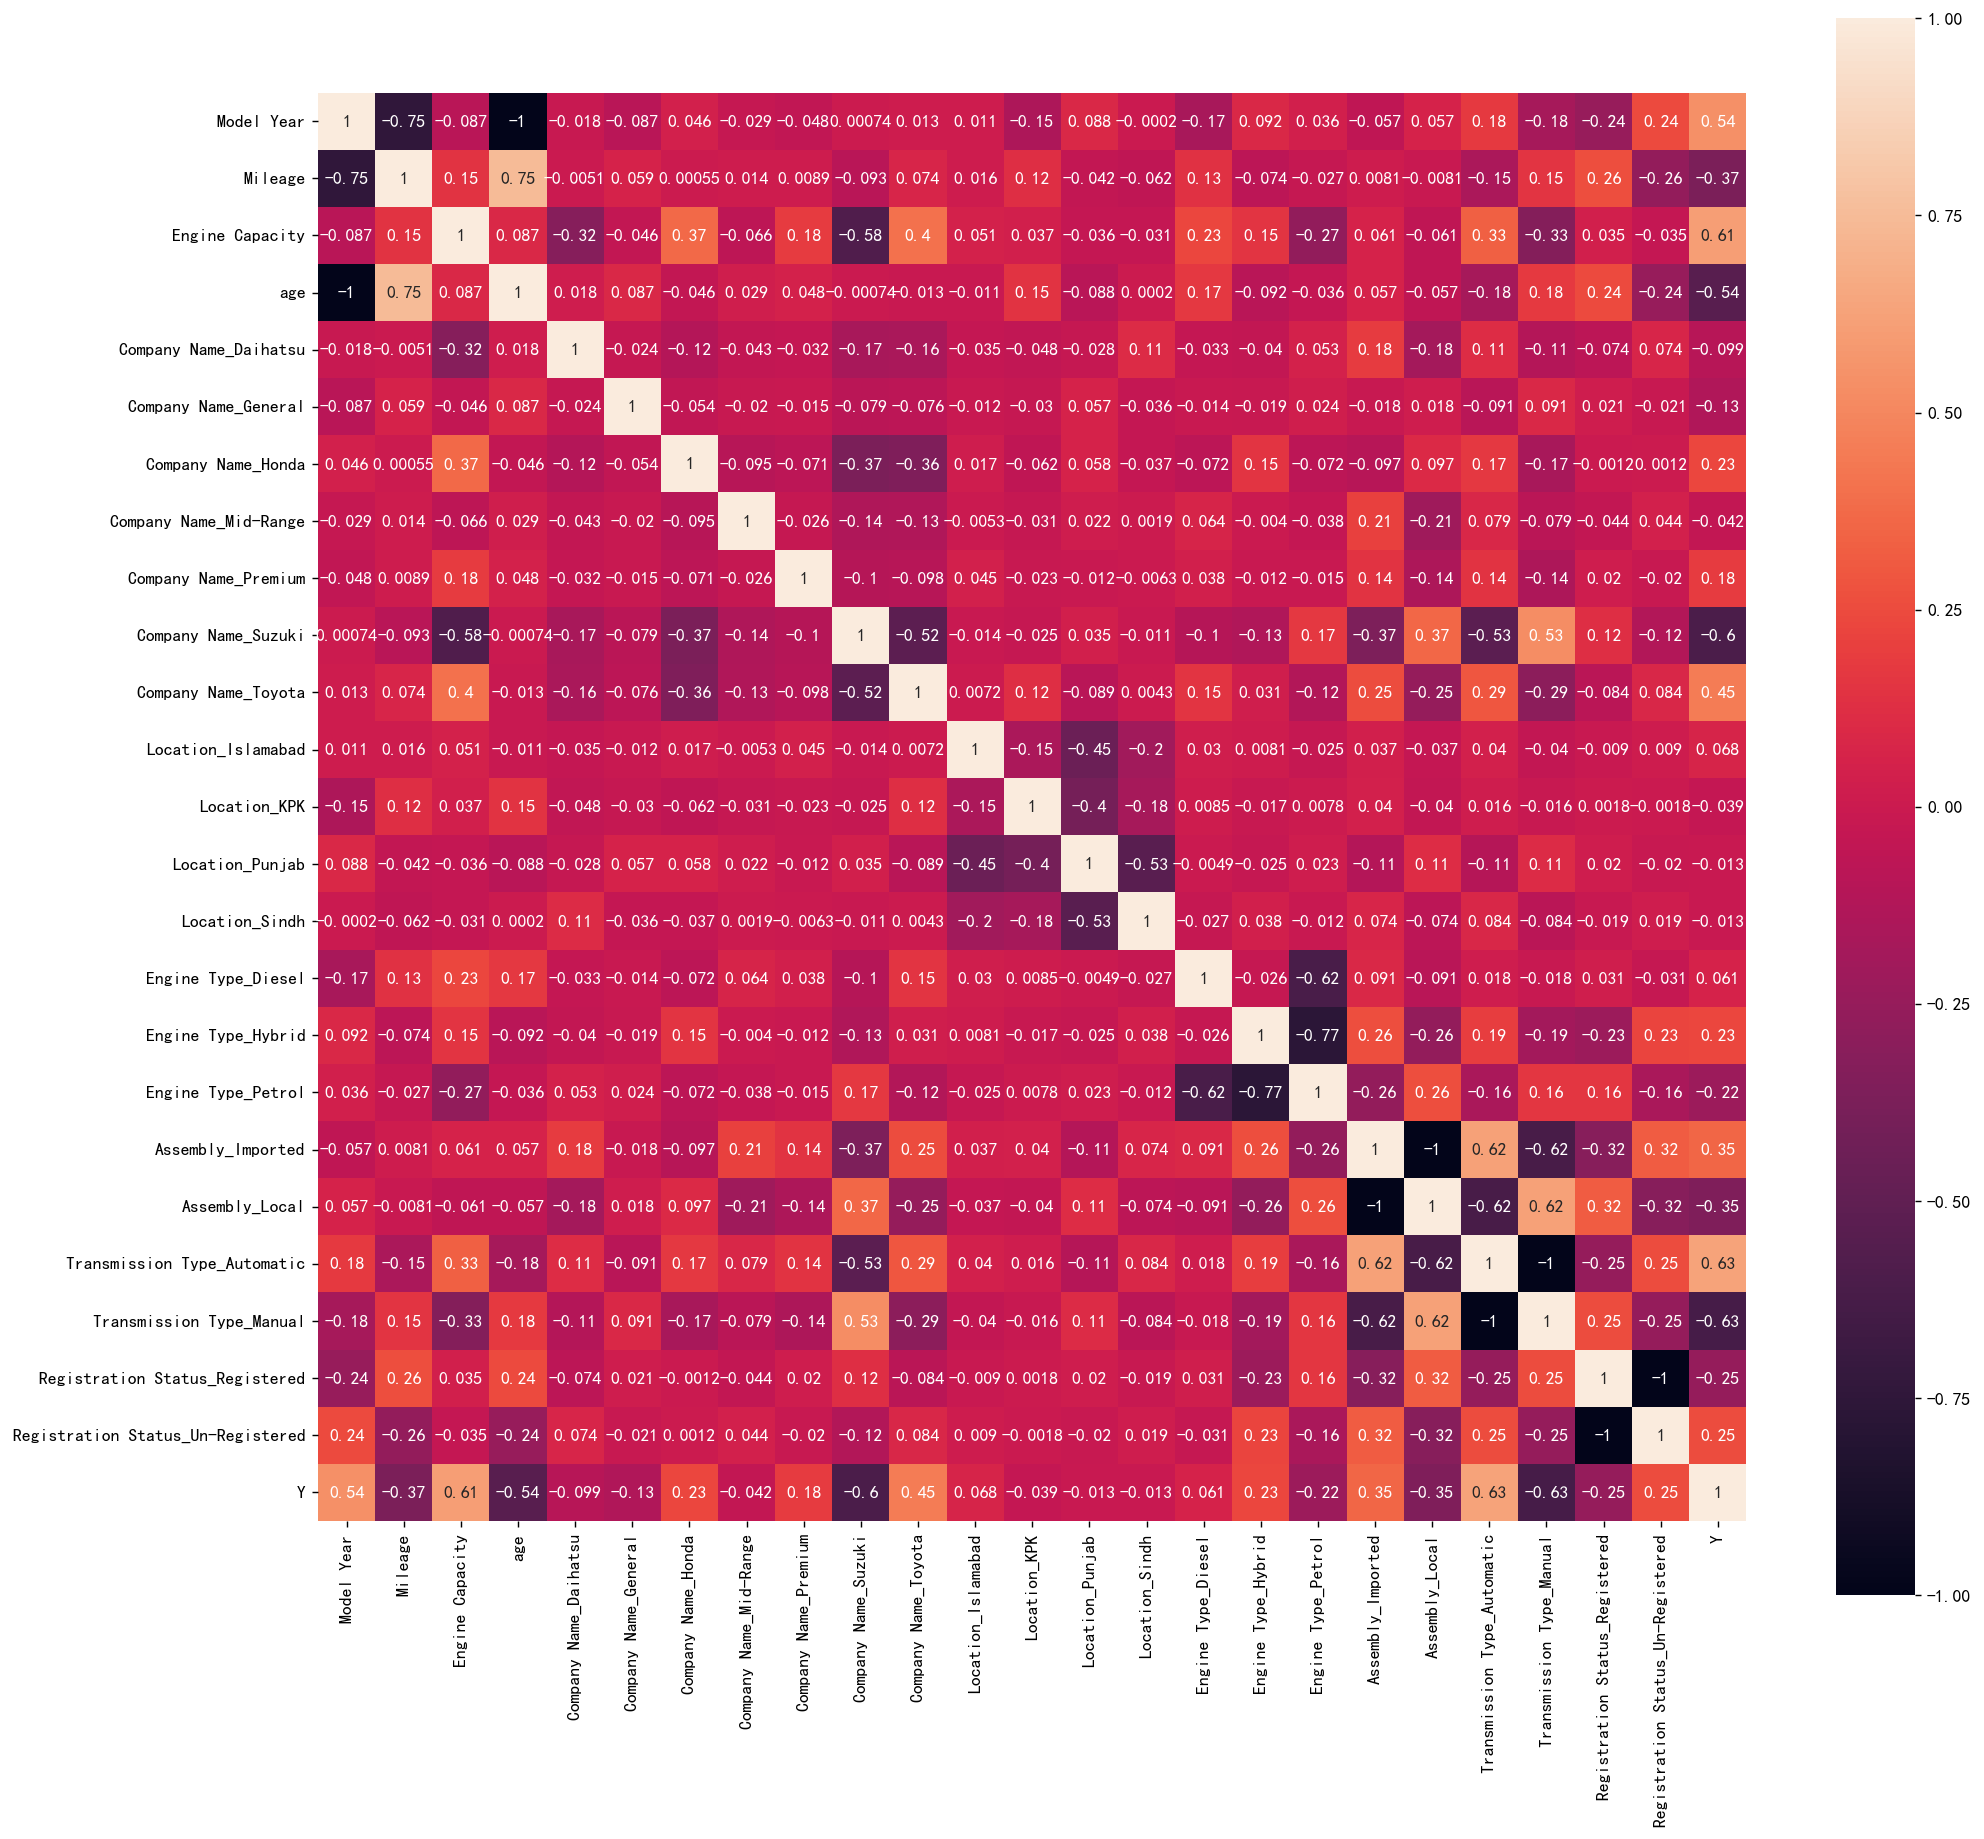

In [31]:
corr = plt.subplots(figsize = (18,16),dpi=128)
corr= sns.heatmap(X_plot.assign(Y=y).corr(method='spearman'),annot=True,square=True)

明显的负相关关系：一些变量对显示为深紫色，表示它们之间存在较强的负相关。例如，“Mileage”和“Engine Capacity”之间似乎有一定的负相关性，这可能意味着发动机容量越大，车辆的里程数越少，这是有意义的，因为大发动机通常消耗更多的燃料。

明显的正相关关系：一些变量对显示为深红色，指示它们之间存在强烈的正相关。例如，“Engine Type_Petrol”和“Company Name_General”可能有较高的正相关，这可能意味着某个特定的汽车制造商更倾向于生产汽油发动机车型。

弱相关或无相关关系：很多变量对显示为接近黑色，表示它们之间几乎没有或没有明显的相关性。这表明很多车辆特征之间可能没有直接的或显著的影响关系。

特定地区或特征的相关性：可以注意到某些特定区域（如Location_JK, Location_Punjab等）和其他变量之间存在不同程度的相关性。这可能表明地区因素对车辆的某些属性有影响，例如某一地区可能更倾向于特定类型的车辆或发动机类型。

## 开始机器学习！

In [32]:
#划分训练集和验证集
from sklearn.model_selection import train_test_split
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.2,random_state=0)

In [33]:
#数据标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_s = scaler.transform(X_val)
print('训练数据形状：')
print(X_train_s.shape,y_train.shape)
print('验证数据形状：')
(X_val_s.shape,y_val.shape,)

训练数据形状：
(35960, 39) (35960,)
验证数据形状：


((8991, 39), (8991,))

### 模型选择

In [34]:
#采用十种模型，对比验证集精度
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [35]:
#线性回归
model1 = LinearRegression()
 
#弹性网回归
model2 = ElasticNet(alpha=0.05, l1_ratio=0.5)
 
#K近邻
model3 = KNeighborsRegressor(n_neighbors=10)
 
#决策树
model4 = DecisionTreeRegressor(random_state=77)
 
#随机森林
model5= RandomForestRegressor(n_estimators=500,  max_features=int(X_train.shape[1]/3) , random_state=0)
 
#梯度提升
model6 = GradientBoostingRegressor(n_estimators=500,random_state=123)
 
#极端梯度提升
model7 =  XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state=0)
 
#轻量梯度提升
model8 = LGBMRegressor(n_estimators=1000,objective='regression', # 默认是二分类
                      random_state=0,force_row_wise=True)
 
#支持向量机
model9 = SVR(kernel="rbf")
 
#神经网络
model10 = MLPRegressor(hidden_layer_sizes=(16,8), random_state=77, max_iter=10000)
 
model_list=[model1,model2,model3,model4,model5,model6,model7,model8,model9,model10]
model_name=['线性回归','惩罚回归','K近邻','决策树','随机森林','梯度提升','极端梯度提升','轻量梯度提升','支持向量机','神经网络']

In [36]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,r2_score
 
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    mape=(abs(y_predict -y_test)/ y_test).mean()
    r_2=r2_score(y_test, y_predict)
    return mae, rmse, mape,r_2  #mse

In [37]:
df_eval=pd.DataFrame(columns=['MAE','RMSE','MAPE','R2'])
for i in range(len(model_list)):
    model_C=model_list[i]
    name=model_name[i]
    print(f'{name}正在训练...')
    model_C.fit(X_train_s, y_train)
    pred=model_C.predict(X_val_s)
    s=evaluation(y_val,pred)
    df_eval.loc[name,:]=list(s)

线性回归正在训练...
惩罚回归正在训练...
K近邻正在训练...
决策树正在训练...
随机森林正在训练...
梯度提升正在训练...
极端梯度提升正在训练...
轻量梯度提升正在训练...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 470
[LightGBM] [Info] Number of data points in the train set: 35960, number of used features: 39
[LightGBM] [Info] Start training from score 1851311.457175
支持向量机正在训练...
神经网络正在训练...


In [38]:
df_eval

,MAE,RMSE,MAPE,R2
线性回归,456633.215289,953052.220538,0.35714,0.719082
惩罚回归,451153.88755,953662.541018,0.349159,0.718722
K近邻,245978.378378,620604.50206,0.13411,0.880882
决策树,196720.820347,502365.739842,0.114621,0.921948
随机森林,154208.512998,336617.396977,0.093902,0.964956
梯度提升,177444.360948,364750.322022,0.10575,0.958853
极端梯度提升,167883.70641,370315.592348,0.098498,0.957588
轻量梯度提升,162109.289113,359696.249855,0.095723,0.959985
支持向量机,983336.952447,1843192.86531,0.676815,-0.050722
神经网络,194900.68056,398786.282628,0.123676,0.950816


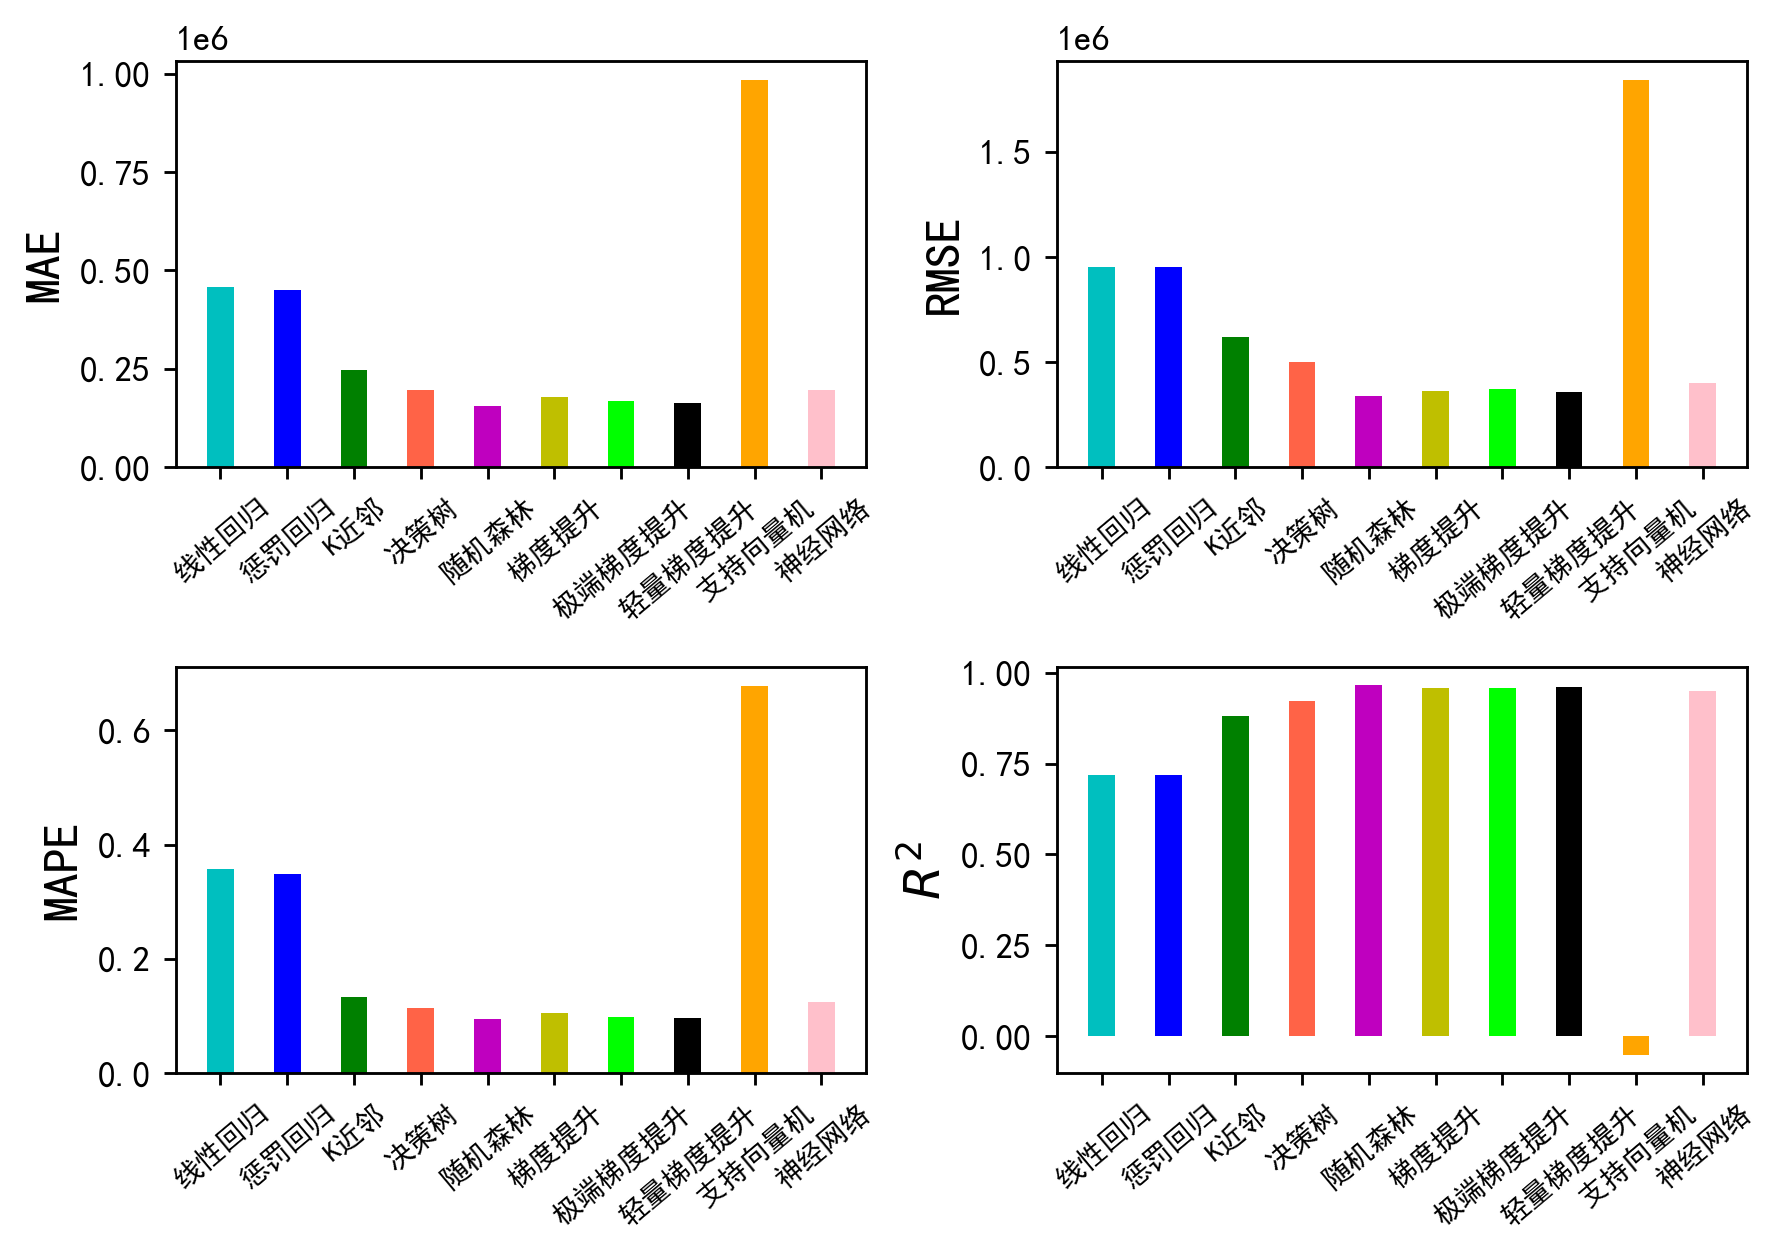

In [39]:
bar_width = 0.4
colors=['c', 'b', 'g', 'tomato', 'm', 'y', 'lime', 'k','orange','pink','grey','tan','purple']
fig, ax = plt.subplots(2,2,figsize=(7,5),dpi=256)
for i,col in enumerate(df_eval.columns):
    n=int(str('22')+str(i+1))
    plt.subplot(n)
    df_col=df_eval[col]
    m =np.arange(len(df_col))
    
    #hatch=['-','/','+','x'],
    plt.bar(x=m,height=df_col.to_numpy(),width=bar_width,color=colors)
    
    #plt.xlabel('Methods',fontsize=12)
    names=df_col.index
    plt.xticks(range(len(df_col)),names,fontsize=8)
    plt.xticks(rotation=40)
    
    if col=='R2':
        plt.ylabel(r'$R^{2}$',fontsize=14)
    else:
        plt.ylabel(col,fontsize=14)
plt.tight_layout()
#plt.savefig('柱状图.jpg',dpi=512)
plt.show()

支持向量机太差劲了.去掉画图

In [40]:
df_eval2=df_eval.loc[['线性回归', '惩罚回归', 'K近邻', '决策树', '随机森林', '梯度提升', '极端梯度提升', '轻量梯度提升','神经网络'],:]

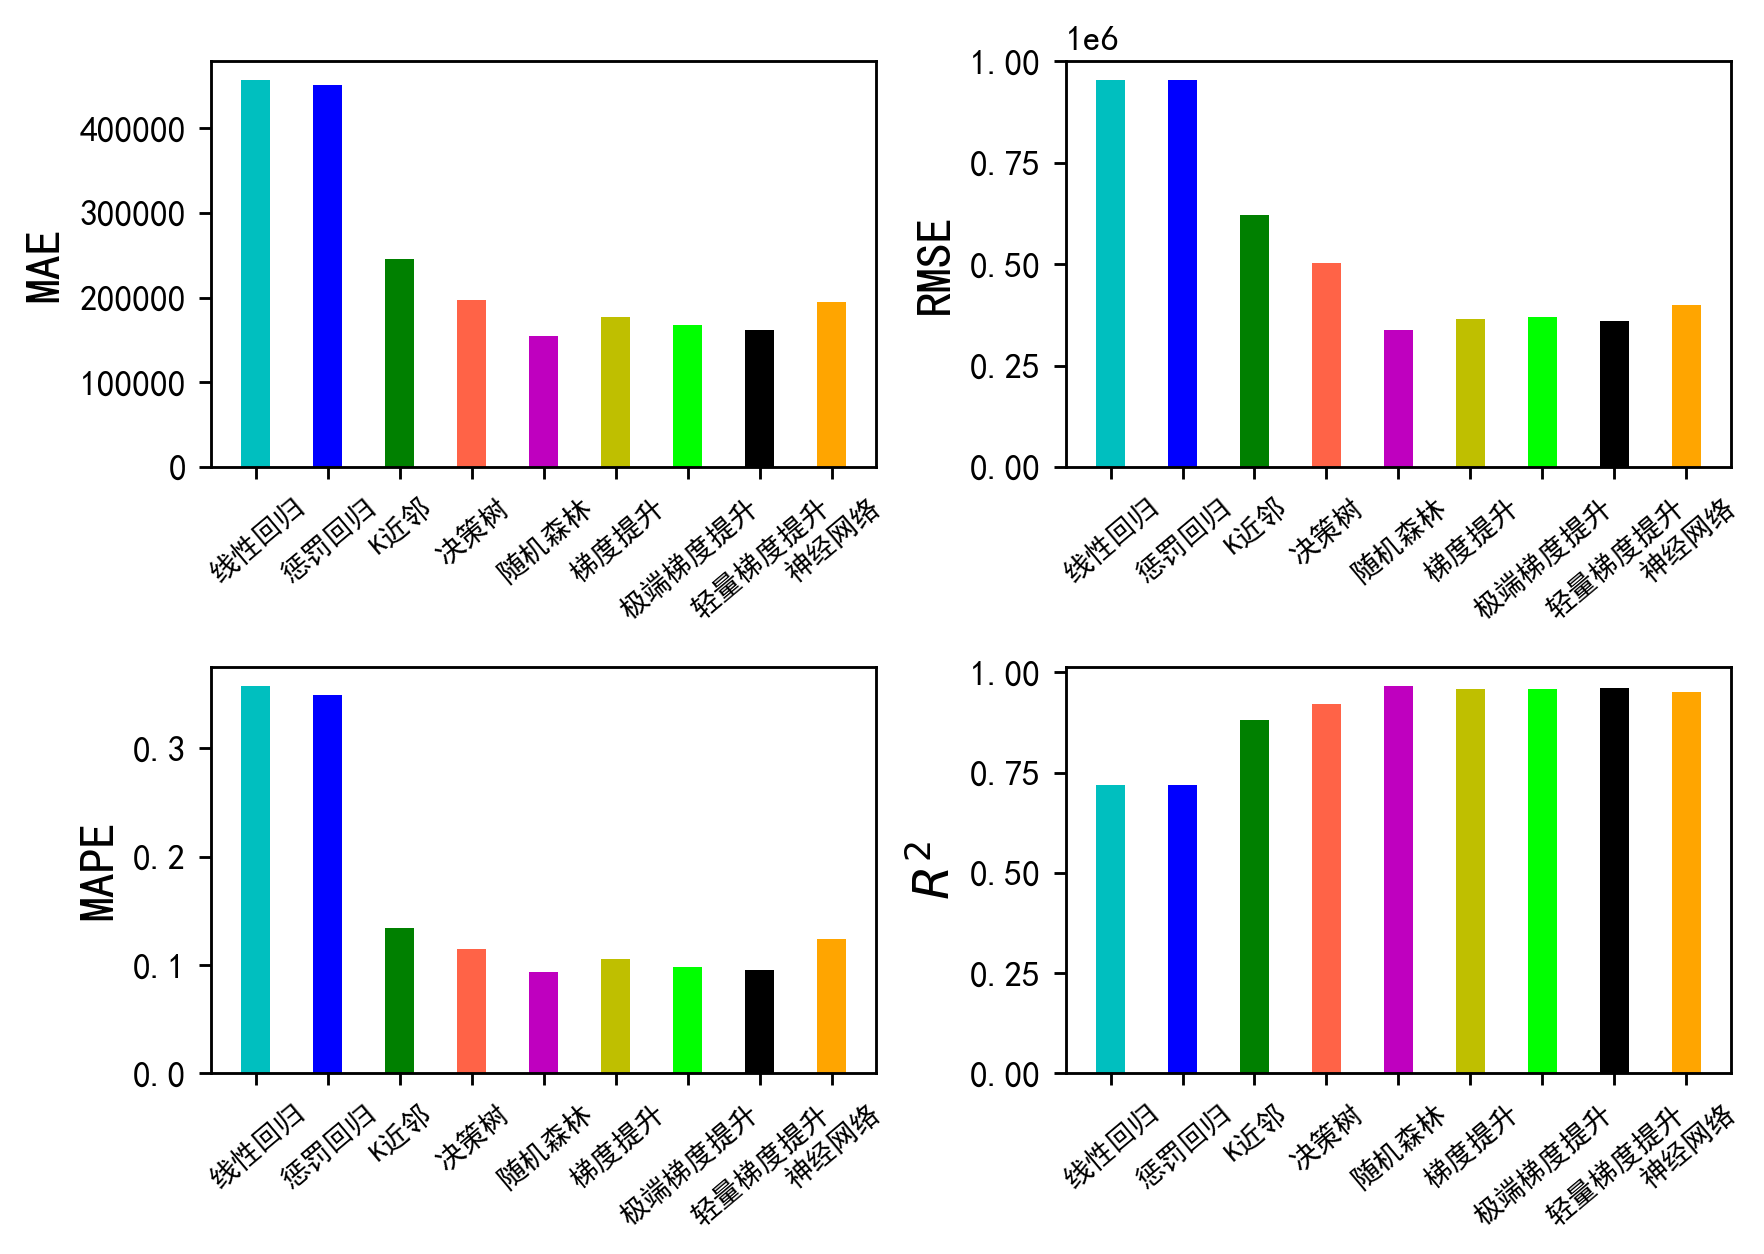

In [41]:

bar_width = 0.4
colors=['c', 'b', 'g', 'tomato', 'm', 'y', 'lime', 'k','orange','pink','grey','tan','purple']
fig, ax = plt.subplots(2,2,figsize=(7,5),dpi=256)
for i,col in enumerate(df_eval.columns):
    n=int(str('22')+str(i+1))
    plt.subplot(n)
    df_col=df_eval2[col]
    m =np.arange(len(df_col))
    
    #hatch=['-','/','+','x'],
    plt.bar(x=m,height=df_col.to_numpy(),width=bar_width,color=colors)
    
    #plt.xlabel('Methods',fontsize=12)
    names=df_col.index
    plt.xticks(range(len(df_col)),names,fontsize=8)
    plt.xticks(rotation=40)
    
    if col=='R2':
        plt.ylabel(r'$R^{2}$',fontsize=14)
    else:
        plt.ylabel(col,fontsize=14)
plt.tight_layout()
#plt.savefig('柱状图.jpg',dpi=512)
plt.show()

集成模型方法都是最好的，也就是XGB,LGBM,RF等。交叉验证

### 交叉验证

In [42]:
#回归问题交叉验证，使用拟合优度，mae,rmse,mape 作为评价标准
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
 
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    mape=(abs(y_predict -y_test)/ y_test).mean()
    r_2=r2_score(y_test, y_predict)
    return mae, rmse, mape
def evaluation2(lis):
    array=np.array(lis)
    return array.mean() , array.std()

In [43]:
def cross_val(model=None,X=None,Y=None,K=5,repeated=1):
    df_mean=pd.DataFrame(columns=['R2','MAE','RMSE','MAPE']) 
    df_std=pd.DataFrame(columns=['R2','MAE','RMSE','MAPE'])
    for n in range(repeated):
        print(f'正在进行第{n+1}次重复K折.....随机数种子为{n}\n')
        kf = KFold(n_splits=K, shuffle=True, random_state=n)
        R2=[]; MAE=[] ; RMSE=[]  ; MAPE=[]
        print(f"    开始本次在{K}折数据上的交叉验证.......\n")
        i=1
        for train_index, test_index in kf.split(X):
            print(f'        正在进行第{i}折的计算')
            X_train=X.values[train_index]
            y_train=y.values[train_index]
            X_test=X.values[test_index]
            y_test=y.values[test_index]
            model.fit(X_train,y_train)
            score=model.score(X_test,y_test)
            R2.append(score)
            pred=model.predict(X_test)
            mae, rmse, mape=evaluation(y_test, pred)
            MAE.append(mae)
            RMSE.append(rmse)
            MAPE.append(mape)
            print(f'        第{i}折的拟合优度为：{round(score,4)}，MAE为{round(mae,4)}，RMSE为{round(rmse,4)}，MAPE为{round(mape,4)}')
            i+=1
        print(f'    ———————————————完成本次的{K}折交叉验证———————————————————\n')
        R2_mean,R2_std=evaluation2(R2)
        MAE_mean,MAE_std=evaluation2(MAE)
        RMSE_mean,RMSE_std=evaluation2(RMSE)
        MAPE_mean,MAPE_std=evaluation2(MAPE)
        print(f'第{n+1}次重复K折，本次{K}折交叉验证的总体拟合优度均值为{R2_mean}，方差为{R2_std}')
        print(f'                               总体MAE均值为{MAE_mean}，方差为{MAE_std}')
        print(f'                               总体RMSE均值为{RMSE_mean}，方差为{RMSE_std}')
        print(f'                               总体MAPE均值为{MAPE_mean}，方差为{MAPE_std}')
        print("\n====================================================================================================================\n")
        df1=pd.DataFrame(dict(zip(['R2','MAE','RMSE','MAPE'],[R2_mean,MAE_mean,RMSE_mean,MAPE_mean])),index=[n])
        df_mean=pd.concat([df_mean,df1])
        df2=pd.DataFrame(dict(zip(['R2','MAE','RMSE','MAPE'],[R2_std,MAE_std,RMSE_std,MAPE_std])),index=[n])
        df_std=pd.concat([df_std,df2])
    return df_mean,df_std

In [44]:
model = LGBMRegressor(n_estimators=1000,objective='regression',random_state=0)
lgb_crosseval,lgb_crosseval2=cross_val(model=model,X=X,Y=y,K=3,repeated=5)

正在进行第1次重复K折.....随机数种子为0

    开始本次在3折数据上的交叉验证.......

        正在进行第1折的计算
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 433
[LightGBM] [Info] Number of data points in the train set: 29967, number of used features: 39
[LightGBM] [Info] Start training from score 1844392.331565
        第1折的拟合优度为：0.9583，MAE为162650.2738，RMSE为378105.1728，MAPE为0.0945
        正在进行第2折的计算
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 29967, number of used features: 39
[LightGBM] [Info] Start training from score 1852822.471385
        第2折的拟合优度为

        第1折的拟合优度为：0.9592，MAE为159842.4559，RMSE为364953.6459，MAPE为0.0936
        正在进行第2折的计算
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 433
[LightGBM] [Info] Number of data points in the train set: 29967, number of used features: 39
[LightGBM] [Info] Start training from score 1856515.467014
        第2折的拟合优度为：0.9543，MAE为159072.8862，RMSE为381848.6183，MAPE为0.0951
        正在进行第3折的计算
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 433
[LightGBM] [Info] Number of data points in the train set: 29968, number of used features: 39
[LightGBM] [Info] Start training from score 1844406.633743


In [45]:
model = XGBRegressor(n_estimators=1000,objective='reg:squarederror',random_state=0)
xgb_crosseval,xgb_crosseval2=cross_val(model=model,X=X,Y=y,K=3,repeated=5)

正在进行第1次重复K折.....随机数种子为0

    开始本次在3折数据上的交叉验证.......

        正在进行第1折的计算
        第1折的拟合优度为：0.9551，MAE为169384.6926，RMSE为392370.1124，MAPE为0.0986
        正在进行第2折的计算
        第2折的拟合优度为：0.952，MAE为168108.2074，RMSE为399340.5245，MAPE为0.1005
        正在进行第3折的计算
        第3折的拟合优度为：0.949，MAE为168477.032，RMSE为395978.9168，MAPE为0.0979
    ———————————————完成本次的3折交叉验证———————————————————

第1次重复K折，本次3折交叉验证的总体拟合优度均值为0.9520185778975915，方差为0.00250071914915724
                               总体MAE均值为168656.64400468444，方差为536.3760932564531
                               总体RMSE均值为395896.5179329955，方差为2846.255249680335
                               总体MAPE均值为0.09898757823471656，方差为0.0010902693152625622


正在进行第2次重复K折.....随机数种子为1

    开始本次在3折数据上的交叉验证.......

        正在进行第1折的计算
        第1折的拟合优度为：0.9469，MAE为173644.1347，RMSE为428808.1765，MAPE为0.1
        正在进行第2折的计算
        第2折的拟合优度为：0.9491，MAE为166875.3141，RMSE为398503.0879，MAPE为0.0979
        正在进行第3折的计算
        第3折的拟合优度为：0.9558，MAE为167179.8904，RMSE为378577.824，MAPE为0.1009
   

In [46]:
model = RandomForestRegressor(n_estimators=500,  max_features=int(X_train.shape[1]/3) , random_state=0)
rf_crosseval,rf_crosseval2=cross_val(model=model,X=X,Y=y,K=3,repeated=5)

正在进行第1次重复K折.....随机数种子为0

    开始本次在3折数据上的交叉验证.......

        正在进行第1折的计算
        第1折的拟合优度为：0.9611，MAE为157267.5788，RMSE为365316.0302，MAPE为0.0945
        正在进行第2折的计算
        第2折的拟合优度为：0.9577，MAE为156186.0576，RMSE为375152.2265，MAPE为0.0962
        正在进行第3折的计算
        第3折的拟合优度为：0.9529，MAE为161008.1575，RMSE为380451.8583，MAPE为0.0951
    ———————————————完成本次的3折交叉验证———————————————————

第1次重复K折，本次3折交叉验证的总体拟合优度均值为0.9571992084607079，方差为0.003355448210745269
                               总体MAE均值为158153.93129099035，方差为2065.974735257521
                               总体RMSE均值为373640.03832366207，方差为6271.010438760449
                               总体MAPE均值为0.09528678313898942，方差为0.0007135741585978033


正在进行第2次重复K折.....随机数种子为1

    开始本次在3折数据上的交叉验证.......

        正在进行第1折的计算
        第1折的拟合优度为：0.953，MAE为163688.7529，RMSE为403303.7754，MAPE为0.0958
        正在进行第2折的计算
        第2折的拟合优度为：0.9555，MAE为155202.8084，RMSE为372416.2953，MAPE为0.0937
        正在进行第3折的计算
        第3折的拟合优度为：0.9633，MAE为154658.2224，RMSE为344910.611，MAPE为0.0

#### 四个评价指标的均值图

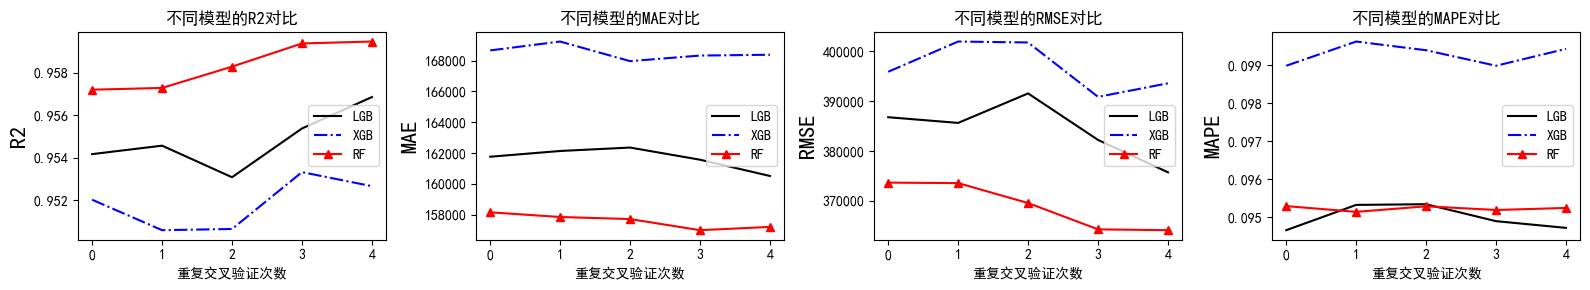

In [47]:
plt.subplots(1,4,figsize=(16,3))
for i,col in enumerate(lgb_crosseval.columns):
    n=int(str('14')+str(i+1))
    plt.subplot(n)
    plt.plot(lgb_crosseval[col], 'k', label='LGB')
    plt.plot(xgb_crosseval[col], 'b-.', label='XGB')
    plt.plot(rf_crosseval[col], 'r-^', label='RF')
    plt.title(f'不同模型的{col}对比')
    plt.xlabel('重复交叉验证次数')
    plt.ylabel(col,fontsize=16)
    plt.legend()
plt.tight_layout()
plt.show()

#### 四个评价指标的方差图

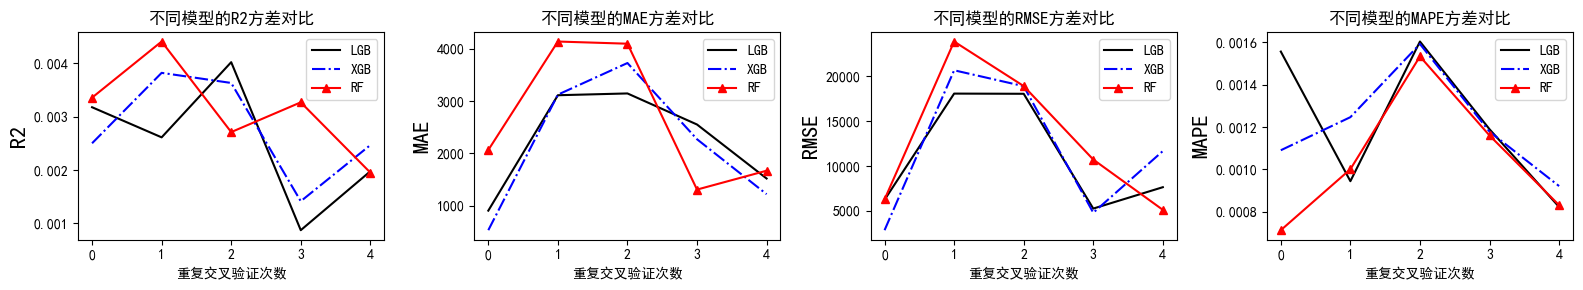

In [48]:
plt.subplots(1,4,figsize=(16,3))
for i,col in enumerate(lgb_crosseval2.columns):
    n=int(str('14')+str(i+1))
    plt.subplot(n)
    plt.plot(lgb_crosseval2[col], 'k', label='LGB')
    plt.plot(xgb_crosseval2[col], 'b-.', label='XGB')
    plt.plot(rf_crosseval2[col], 'r-^', label='RF')
    plt.title(f'不同模型的{col}方差对比')
    plt.xlabel('重复交叉验证次数')
    plt.ylabel(col,fontsize=16)
    plt.legend()
plt.tight_layout()
plt.show()

#### 随机森林的效果最好，下面对随机森林搜索超参数

### 搜超参数

In [49]:
#利用K折交叉验证搜索最优超参数
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [50]:
# 设置参数分布
param_distributions = {
    'n_estimators': [100, 300, 500, 800,1000],  # 树的数量
    'max_features': range(9, 15),  # 最大特征数
    'max_depth': range(8, 13),  # 最大深度
}

# 定义交叉验证
kfold = KFold(n_splits=3, shuffle=True, random_state=1)

# 初始化随机森林回归器
model = RandomForestRegressor(random_state=0)
# 使用 RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, 
                                   n_iter=50, cv=kfold, verbose=2, random_state=0, n_jobs=-1)
# 拟合模型
random_search.fit(X_train_s, y_train)
# 打印最佳参数
print("Best parameters:", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'n_estimators': 1000, 'max_features': 13, 'max_depth': 12}


In [51]:
model = random_search.best_estimator_
model.score(X_val_s, y_val)

0.9650667559434117

In [52]:
model=RandomForestRegressor(n_estimators=1000,  max_features=13 ,max_depth=12, random_state=0)
model.fit(X_train_s, y_train)
model.score(X_val_s, y_val)

0.9650667559434117

### 变量重要性排序图

In [53]:
model=RandomForestRegressor(n_estimators=1000,  max_features=13 ,max_depth=12, random_state=0)
model.fit(X.to_numpy(),y.to_numpy())
model.score(X.to_numpy(), y.to_numpy())

0.9780515841588863

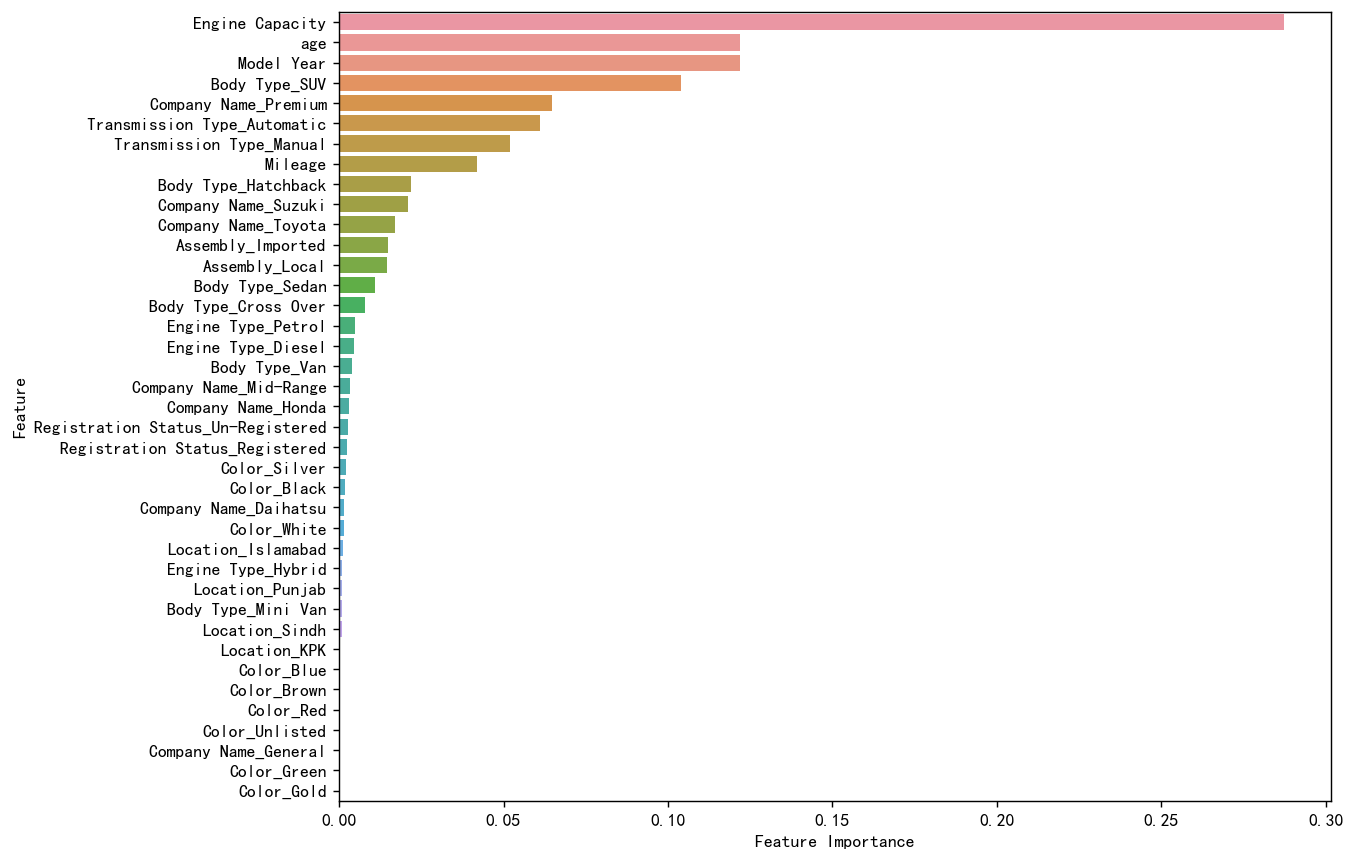

In [54]:
sorted_index = model.feature_importances_.argsort()[::-1]
plt.figure(figsize=(10, 8),dpi=128) # 可以调整尺寸以适应所有特征

# 使用 seaborn 来绘制条形图
sns.barplot(x=model.feature_importances_[sorted_index], y=X.columns[sorted_index], orient='h')
plt.xlabel('Feature Importance')  # x轴标签
plt.ylabel('Feature')             # y轴标签
plt.show()

#### 只选前15个画图

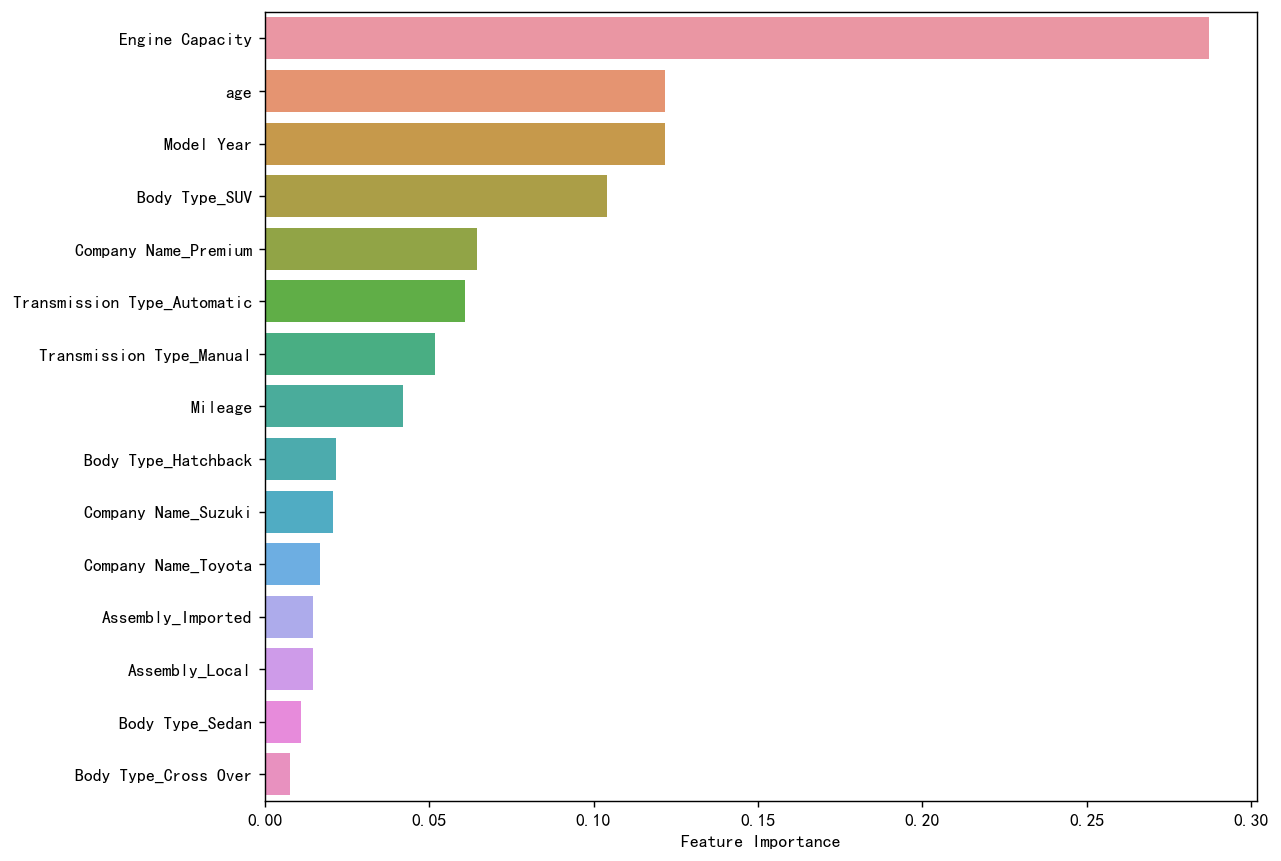

In [55]:
sorted_index = model.feature_importances_.argsort()[::-1][:15]
plt.figure(figsize=(10, 8),dpi=128) # 可以调整尺寸以适应所有特征

# 使用 seaborn 来绘制条形图
sns.barplot(x=model.feature_importances_[sorted_index][:15], y=X.columns[sorted_index][:15], orient='h')
plt.xlabel('Feature Importance')  # x轴标签
plt.ylabel('')             # y轴标签
plt.show()